# Technical Test - KSG - Guido Bonomini
## Creating a Weather Agent using a TemperatureTool and a CoordinatesTool

### Step-by-Step Overview
This notebook consists of four main sections:

- Setting up two Servers (Flask) each providing a unique functionality:

    - A Temperature Server returns the current temperature of a given city.

    - A Coordinates Server that returns the coordinates for a specific place based on city names.

- Creating LangChain Tools: These tools allow our AI agent to interact seamlessly with the MCP servers we just built.

- Building the AI Agent with LangChain: Using LangChain's React agent framework, we'll set up an intelligent AI agent to leverage our custom tools.

- Testing the Weather Agent: Finally, we'll run queries through the agent and observe its responses.

### Step 1: Creating Servers with Flask

MCP (Multi-Content Protocol) servers allow us to create standardized HTTP-based APIs that our AI agent can use as tools. FastAPI is chosen due to its high performance, simplicity, and modern features.

Temperature Server:

In [ ]:
import requests
import os
from flask import Flask, request, jsonify
from threading import Thread

OPENWEATHER_API_KEY = "9ac02708120114502d95d91b9b8277f4"  # Replace with your actual API key

def run_temperature_server():
    app = Flask("TemperatureServer")

    @app.route('/temperature', methods=['POST'])
    def temperature():
        data = request.json
        lat = data.get("lat", "").strip()
        lon = data.get("lon", "").strip()
        print(data)

        url = "https://api.openweathermap.org/data/2.5/weather"
        params = {
            "lon": lon,
            "lat": lat,
            "appid": OPENWEATHER_API_KEY
        }

        try:
            response = requests.get(url, params=params)
            print(response.text)
            response.raise_for_status()
            weather_data = response.json()
            print(weather_data)

            return jsonify(weather_data)
        except requests.RequestException as e:
            return jsonify({"error": str(e)}), 500
        except KeyError:
            return jsonify({"error": "Unexpected response format"}), 500

    app.run(port=5001)

# Start in background thread
Thread(target=run_temperature_server, daemon=True).start()



 * Serving Flask app 'TemperatureServer'
 * Debug mode: off


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit


{'lat': '35.3192808', 'lon': '139.5469627'}


127.0.0.1 - - [21/Jul/2025 01:23:19] "POST /temperature HTTP/1.1" 200 -


{"coord":{"lon":139.547,"lat":35.3193},"weather":[{"id":800,"main":"Clear","description":"clear sky","icon":"01d"}],"base":"stations","main":{"temp":306.95,"feels_like":311.44,"temp_min":306.62,"temp_max":307.8,"pressure":1016,"humidity":51,"sea_level":1016,"grnd_level":1014},"visibility":10000,"wind":{"speed":7.27,"deg":194,"gust":7.11},"clouds":{"all":5},"dt":1753071798,"sys":{"type":2,"id":20510,"country":"JP","sunrise":1753040521,"sunset":1753091641},"timezone":32400,"id":1860672,"name":"Kamakura","cod":200}
{'coord': {'lon': 139.547, 'lat': 35.3193}, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'base': 'stations', 'main': {'temp': 306.95, 'feels_like': 311.44, 'temp_min': 306.62, 'temp_max': 307.8, 'pressure': 1016, 'humidity': 51, 'sea_level': 1016, 'grnd_level': 1014}, 'visibility': 10000, 'wind': {'speed': 7.27, 'deg': 194, 'gust': 7.11}, 'clouds': {'all': 5}, 'dt': 1753071798, 'sys': {'type': 2, 'id': 20510, 'country': 'JP', 'sunrise': 

127.0.0.1 - - [21/Jul/2025 01:24:35] "POST /temperature HTTP/1.1" 200 -


{"coord":{"lon":132.4536,"lat":34.3924},"weather":[{"id":801,"main":"Clouds","description":"few clouds","icon":"02d"}],"base":"stations","main":{"temp":305.01,"feels_like":311.78,"temp_min":305.01,"temp_max":305.01,"pressure":1017,"humidity":66,"sea_level":1017,"grnd_level":996},"visibility":10000,"wind":{"speed":1.72,"deg":221,"gust":3.11},"clouds":{"all":14},"dt":1753071458,"sys":{"country":"JP","sunrise":1753042356,"sunset":1753093211},"timezone":32400,"id":1860483,"name":"Kami-nagarekawachō","cod":200}
{'coord': {'lon': 132.4536, 'lat': 34.3924}, 'weather': [{'id': 801, 'main': 'Clouds', 'description': 'few clouds', 'icon': '02d'}], 'base': 'stations', 'main': {'temp': 305.01, 'feels_like': 311.78, 'temp_min': 305.01, 'temp_max': 305.01, 'pressure': 1017, 'humidity': 66, 'sea_level': 1017, 'grnd_level': 996}, 'visibility': 10000, 'wind': {'speed': 1.72, 'deg': 221, 'gust': 3.11}, 'clouds': {'all': 14}, 'dt': 1753071458, 'sys': {'country': 'JP', 'sunrise': 1753042356, 'sunset': 1753

Coordinates Server:

In [ ]:
from flask import Flask, request, jsonify
from threading import Thread

def run_coordinates_server():
    app = Flask("CoordinatesServer")

    @app.route('/coordinates', methods=['POST'])
    def coordinates():
        data = request.json
        location = data.get("location", "").lower()
        print(location)
        url = "https://nominatim.openstreetmap.org/search"
        params = {
            "q": location,
            "format": "json",
            "limit": 5
        }
        headers = {"User-Agent": "LangChainGeocoder/1.0"}

        response = requests.get(url, params=params, headers=headers)
        response.raise_for_status()

        data = response.json()
        print(data)
        if not data:
            return "No coordinates found for the given description."

        lat = data[0]['lat']
        lon = data[0]['lon']
        display_name = data[0].get('display_name', 'Unknown location')
        return jsonify({"location": location, "lat": lat, "lon": lon, "display_name": display_name})

    app.run(port=5002)

# Start in background thread
Thread(target=run_coordinates_server, daemon=True).start()


 * Serving Flask app 'CoordinatesServer'
 * Debug mode: off


 * Running on http://127.0.0.1:5002
Press CTRL+C to quit


kamakura


127.0.0.1 - - [21/Jul/2025 01:23:15] "POST /coordinates HTTP/1.1" 200 -


[{'place_id': 244361420, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 2689445, 'lat': '35.3192808', 'lon': '139.5469627', 'class': 'boundary', 'type': 'administrative', 'place_rank': 14, 'importance': 0.5755946953129426, 'addresstype': 'city', 'name': '鎌倉市', 'display_name': '鎌倉市, 神奈川県, 日本', 'boundingbox': ['35.2665593', '35.3683147', '139.4885482', '139.5931730']}, {'place_id': 245562868, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 18076918, 'lat': '35.7459954', 'lon': '139.8787501', 'class': 'boundary', 'type': 'administrative', 'place_rank': 18, 'importance': 0.2661671604250825, 'addresstype': 'quarter', 'name': '鎌倉', 'display_name': '鎌倉, 葛飾区, 東京都, 125-0053, 日本', 'boundingbox': ['35.7402495', '35.7519079', '139.8730991', '139.8850702']}]
hiroshima


127.0.0.1 - - [21/Jul/2025 01:24:31] "POST /coordinates HTTP/1.1" 200 -


[{'place_id': 247497758, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 4097196, 'lat': '34.3917241', 'lon': '132.4517589', 'class': 'boundary', 'type': 'administrative', 'place_rank': 14, 'importance': 0.6698720351472898, 'addresstype': 'city', 'name': '広島市', 'display_name': '広島市, 広島県, 日本', 'boundingbox': ['34.2888020', '34.6147670', '132.1785450', '132.6960980']}]


### Step 2: Creating LangChain Tools

To enable the AI agent to interact with our MCP servers, we must create LangChain tools. These tools act as intermediaries, sending HTTP requests to our FastAPI endpoints and fetching the responses.

In [3]:
from typing import Type
from pydantic import BaseModel
from langchain.tools import BaseTool
import requests
import asyncio

# Input schema for temperature
class TemperatureInput(BaseModel):
    lat: str
    lon: str

# Input schema for coordinates
class CoordinatesInput(BaseModel):
    location: str

class TemperatureMCPTool(BaseTool):
    name: str = "TemperatureMCPTool"
    description: str = "Use this tool to get the current temperature by providing latitude and longitude."
    args_schema: Type[BaseModel] = TemperatureInput

    def _run(self, lat: str, lon: str) -> str:
        response = requests.post("http://localhost:5001/temperature", json={"lat": lat, "lon": lon})
        return response.text

    async def _arun(self, lat: str, lon: str) -> str:
        loop = asyncio.get_event_loop()
        return await loop.run_in_executor(None, self._run, lat, lon)

class CoordinatesMCPTool(BaseTool):
    name: str = "CoordinatesMCPTool"
    description: str = "Use this tool to get the coordinates for a given location (e.g. city or place)."
    args_schema: Type[BaseModel] = CoordinatesInput

    def _run(self, location: str) -> str:
        response = requests.post("http://localhost:5002/coordinates", json={"location": location})
        return response.text

    async def _arun(self, location: str) -> str:
        loop = asyncio.get_event_loop()
        return await loop.run_in_executor(None, self._run, location)


### Step 3: Building the AI Agent with LangChain

With our tools ready, we now integrate them into an Agent. The agent is built using the React agent pattern, allowing it to dynamically decide when and how to use our custom MCP tools to answer queries.

In [4]:
from langchain.chat_models import AzureChatOpenAI
from langgraph.prebuilt import create_react_agent

def create_weather_agent(llm: AzureChatOpenAI, prompt:str, name: str):
    temperature_tool = TemperatureMCPTool()
    coordinates_tool = CoordinatesMCPTool()
    
    weather_agent = create_react_agent(
        llm, 
        tools=[coordinates_tool, temperature_tool], 
        prompt=prompt,
        name=name
    )
    
    # Optional tagging for filtering or identification
    weather_agent = weather_agent.with_config(tags=[name])
    
    return weather_agent


### Step 4: Testing the Weather Agent

Let's now test our Weather Agent to verify that it correctly fetches data from the MCP tools and responds intelligently.

In [5]:
import os
import random
import json
import uuid
import requests
import logging
import functools
import operator
from pydantic import BaseModel
from typing import Annotated, Sequence, Literal
from typing_extensions import TypedDict

from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.serde.jsonplus import JsonPlusSerializer


from common.cosmosdb_checkpointer import CosmosDBSaver, AsyncCosmosDBSaver

#custom libraries that we will use later in the app
from common.utils import (
    create_docsearch_agent,
    create_csvsearch_agent,
    create_sqlsearch_agent,
    create_websearch_agent,
    create_apisearch_agent,
    reduce_openapi_spec
)

from common.prompts import (
    CUSTOM_CHATBOT_PREFIX,
    WEATHER_AGENT_PROMPT_TEXT,
    DOCSEARCH_PROMPT_TEXT,
    CSV_AGENT_PROMPT_TEXT,
    MSSQL_AGENT_PROMPT_TEXT,
    WEBSEARCH_PROMPT_TEXT,
    APISEARCH_PROMPT_TEXT,
    SUPERVISOR_PROMPT_TEXT
)

from dotenv import load_dotenv
load_dotenv("credentials.env")

from IPython.display import Image, Markdown, Audio, display 

from common.audio_utils import text_to_speech 

def play_audio(file_path):
    """Play an audio file in Jupyter Notebook."""
    display(Audio(file_path, autoplay=True))

def printmd(string):
    # Remove ```markdown and ``` from the text
    clean_content = re.sub(r'^```markdown\n', '', string)
    clean_content = re.sub(r'^```\n', '', clean_content)
    clean_content = re.sub(r'\n```$', '', clean_content)

    # Escape dollar signs to prevent LaTeX rendering
    clean_content = clean_content.replace('$', r'\$')
    display(Markdown(clean_content))

In [6]:
os.environ["OPENAI_API_VERSION"] = os.environ["AZURE_OPENAI_API_VERSION"]

In [7]:
COMPLETION_TOKENS = 5000

llm = AzureChatOpenAI(deployment_name=os.environ["GPT4o_DEPLOYMENT_NAME"], 
                      temperature=0, max_tokens=COMPLETION_TOKENS, 
                      streaming=True)


### Creating all of the Specialized Agents to use with the Supervisor

#### **Weather Agent**

In [8]:
weather_agent = create_weather_agent(llm, 
                                     prompt=CUSTOM_CHATBOT_PREFIX + WEATHER_AGENT_PROMPT_TEXT,
                                     name="Weather")

#### **DocSearch Agent**

In [9]:
indexes = ["srch-index-files", "srch-index-csv", "srch-index-books"]
docsearch_agent = create_docsearch_agent(llm,indexes,k=20,reranker_th=1.5,
                                         prompt=CUSTOM_CHATBOT_PREFIX + DOCSEARCH_PROMPT_TEXT,
                                         sas_token=os.environ['BLOB_SAS_TOKEN'],
                                         name="DocSearch"
                                        )

#### **CSVSearch Agent**

In [10]:
file_url = "./data/all-states-history.csv"
csvsearch_agent = create_csvsearch_agent(llm,
                                         prompt=CUSTOM_CHATBOT_PREFIX + CSV_AGENT_PROMPT_TEXT.format(file_url=file_url),
                                         name="CSVSearch")

#### **SQLSearch Agent**

In [11]:
sqlsearch_agent = create_sqlsearch_agent(llm, 
                                     prompt=CUSTOM_CHATBOT_PREFIX + MSSQL_AGENT_PROMPT_TEXT,
                                     name="SQLSearch")

#### **WebSearch Agent**

In [12]:
websearch_agent = create_websearch_agent(llm, 
                                     prompt=CUSTOM_CHATBOT_PREFIX + WEBSEARCH_PROMPT_TEXT,
                                     name="WebSearch")

#### **APISearch Agent**

In [13]:
api_file_path = "./data/openapi_kraken.json"
with open(api_file_path, 'r') as file:
    spec = json.load(file)
    
reduced_api_spec = reduce_openapi_spec(spec)

apisearch_agent = create_apisearch_agent(llm, 
                                     prompt=CUSTOM_CHATBOT_PREFIX + APISEARCH_PROMPT_TEXT.format(api_spec=reduced_api_spec),
                                     name="APISearch")

### Helper Print and Audio Functions

Define functions to print the events and respond with Audio.

These are two different ways to print and stream the answers and events

In [14]:
# Define a sync function to stream graph updates
def stream_graph_updates_sync(user_input: str, graph, config):
    last_agent_message = ""  # Will hold the latest AIMessage content

    for event in graph.stream({"messages": [("human", user_input)]}, config, stream_mode="updates"):
        # print(event)  # Print the raw event (keep this for debugging if needed)

        # Each event is a dict, e.g. {"WebSearchAgent": {...}} or {"supervisor": {"messages": [...]}}
        if isinstance(event, dict):
            for key, value in event.items():
                # If this is an agent or supervisor event, store the latest message content
                # (No change here—this correctly captures all updates, with the final one being the supervisor's response)
                if isinstance(value, dict) and "messages" in value:
                    messages = value["messages"]
                    if messages:
                        last_msg = messages[-1]
                        # Only update last_agent_message if it's an AIMessage with content
                        # (Added this check to avoid overwriting with intermediate ToolMessages or empty contents;
                        # ensures we prioritize AIMessages, which are the actual responses)
                        if hasattr(last_msg, 'content') and last_msg.content and not getattr(last_msg, 'tool_calls', None):
                            last_agent_message = last_msg.content

    # It triggers after all events, using the final last_agent_message (supervisor's response)
    if last_agent_message:
        print(last_agent_message)
        tts_audio_file = text_to_speech(last_agent_message)
        if tts_audio_file:
            play_audio(tts_audio_file)



# Define an async function to stream events async
async def stream_graph_updates_async(user_input: str, graph, config, exclude_tags_list=[] ):
    inputs = {"messages": [("human", user_input)]}
    complete_text = ""  # Store the full response text for TTS
    if config is None:
        config = {}

    async for event in graph.astream_events(inputs, config, exclude_tags=exclude_tags_list, version="v2"):
        # print(event)
        
        # Added: Reset complete_text on each chat model start from the 'agent' node
        # This ensures complete_text only holds the output from the most recent model call,
        # which will be the final supervisor response at the end of processing
        if (
            event["event"] == "on_chat_model_start"
            and event["metadata"].get("langgraph_node") == "agent"
        ):
            # print(event)
            complete_text = ""
        
        if (
            event["event"] == "on_chat_model_stream"  # Ensure the event is a chat stream event
            and event["metadata"].get("langgraph_node") == "agent"
        ):
            # Print the content of the chunk progressively
            chunk_text = event["data"]["chunk"].content
            print(chunk_text, end="", flush=True)
            complete_text += chunk_text  # Accumulate chunks of text

        if (
            event["event"] == "on_tool_start"  
            and event["metadata"].get("langgraph_node") == "tools"  # Ensure it's from the tools node
        ):
            print("\n--")
            print(f"Starting tool: {event['name']} with inputs: {event['data'].get('input')}")
            print("--")
        if (
            event["event"] == "on_tool_end"  # Ensure the event is a chat stream event
            and event["metadata"].get("langgraph_node") == "tools"  # Ensure it's from the chatbot node
        ):
            print("\n--")
            print(f"Done tool: {event['name']}")
            print("--")
            
    # Moved TTS here, outside the loop (key fix: triggers after all events, using the final accumulated complete_text)
    # Removed the 'next' == 'FINISH' check, as it's not present in events and unnecessary
    if complete_text:
        tts_audio_file = text_to_speech(complete_text)
        if tts_audio_file:
            play_audio(tts_audio_file)
    

### Create supervisor with `langgraph-supervisor`

To implement out multi-agent system, we will use [`create_supervisor`]from the prebuilt `langgraph-supervisor` library:


In [15]:
from langgraph_supervisor import create_supervisor

supervisor = create_supervisor(
    model=llm,
    agents=[weather_agent, docsearch_agent, csvsearch_agent, websearch_agent, apisearch_agent],
    prompt=(
        "You are a supervisor managing several agents:\n"
        "- a WeatherSearch agent. Assign tasks to this agent if the user states: @weathersearch.\n"
        "- a DocSearch agent. Assign tasks to this agent if the user states: @docsearch.\n"
        "- a CSVSearch agent. Assign tasks to this agent if the user states: @csvsearch.\n"
        "- a WebSearch agent. Assign tasks to this agent if the user states: @websearch.\n"
        "- a ApiSearch agent. Assign tasks to this agent if the user states: @apisearch.\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
)

checkpointer_sync = CosmosDBSaver(
    endpoint=os.environ["AZURE_COSMOSDB_ENDPOINT"],
    key=os.environ["AZURE_COSMOSDB_KEY"],
    database_name=os.environ["AZURE_COSMOSDB_NAME"],
    container_name=os.environ["AZURE_COSMOSDB_CONTAINER_NAME"],
    serde=JsonPlusSerializer(),
)

# Manually initialize resources
checkpointer_sync.setup()

# Compile the synchronous graph after setup is complete
graph_sync = supervisor.compile(checkpointer=checkpointer_sync)

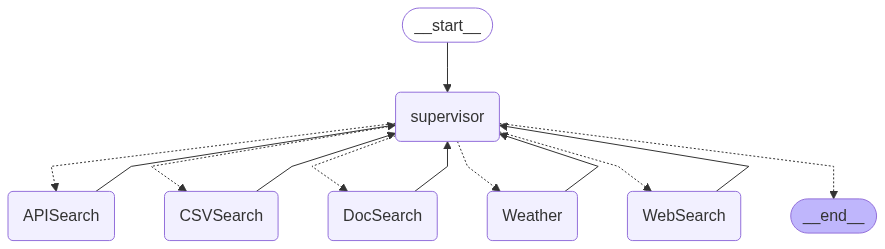

In [16]:
import uuid
# Define a test thread_id to store in the persistent storage
config_sync = {"configurable": {"thread_id": str(uuid.uuid4())}}

display(Image(graph_sync.get_graph().draw_mermaid_png()))

### Run SYNC App

In [ ]:
# Run the synchronous agent
print("Running the synchronous agent:")
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    try:
        stream_graph_updates_sync(user_input, graph_sync, config_sync)
    except Exception as e:
        print(f"Error during synchronous update: {e}")

Running the synchronous agent:


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


The weather in Kamakura is clear with a temperature of 33.8°C (92.8°F). Let me know if you need anything else!


Could you specify which cities you'd like information for? If you'd like me to proceed, please use @weathersearch.


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


The weather in Hiroshima is partly cloudy with a temperature of 31.9°C (89.4°F). Let me know if you'd like updates for other cities!


### Construct the ASYNC graph of our application

### Let's talk to our Engine ASYNC chat bot now

In [ ]:
# We can as well avoid the .setup() call of the cosmosDB by using the with statement as below
async def run_async_agent():
    async with AsyncCosmosDBSaver(
        endpoint=os.environ["AZURE_COSMOSDB_ENDPOINT"],
        key=os.environ["AZURE_COSMOSDB_KEY"],
        database_name=os.environ["AZURE_COSMOSDB_NAME"],
        container_name=os.environ["AZURE_COSMOSDB_CONTAINER_NAME"],
        serde=JsonPlusSerializer(),
    ) as checkpointer_async:
        # Compile the asynchronous graph
        graph_async = supervisor.compile(checkpointer=checkpointer_async)
        # Define a test thread_id to store in the persistent storage
        config_async = {"configurable": {"thread_id": str(uuid.uuid4())}}



        print("\nRunning the asynchronous agent:")
        while True:
            user_input = input("User: ")
            if user_input.lower() in ["quit", "exit", "q"]:
                print("Goodbye!")
                break
            await stream_graph_updates_async(user_input, graph_async ,config_async, exclude_tags_list=["WeatherSearch"])

# Run the asynchronous agent
await run_async_agent()

# Summary

Great!, We just built the enhanced super RAG Agent! a Multi-Agentic architecture with persistent memory!.


We can have many tools or subagents to accomplish different tasks, including connecting to APIs, dealing with File Systems, and even using Humans as Tools. For more reference see [HERE](https://python.langchain.com/docs/integrations/tools/)

# NEXT
It is time now to use all the functions and prompts build so far and build a Web application.
The Next notebook will guide you on how to build:

1) A Bot API Backend
2) A Frontend UI with a Search and Webchat interfaces